In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "medium_mlr_hier"
n = 1000
signal_to_noise = 4


nsamples = 40
L = 5

ranks = np.array([5, 4, 3, 2, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=1000.0
level=1, num_groups=4, mean_size=250.0
level=2, num_groups=8, mean_size=125.0
level=3, num_groups=16, mean_size=62.5
level=4, num_groups=1000, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=14.177437392264448, noise_var=3.594951211198346
SNR=3.943707872335358, signal_to_noise=4


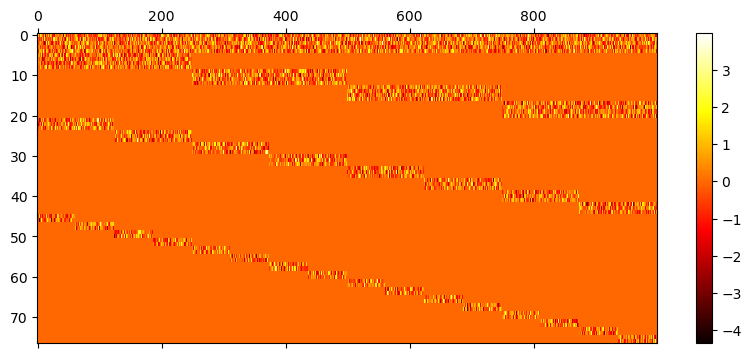

(1000, 77)


In [6]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [8]:
row_selectors, si_groups, F_hpart = mfm.row_col_selections(hpart)

num_levels=5, num_sparsities=16
(16, 4) [ 0  3  7 15]


# True model loglikelihoods

In [9]:
C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)
Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
del C
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]
# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

true_Sigma = mfm.perm_hat_Sigma_sp(true_sparse_F, true_D_noise)
tr_lu, tr_piv = scipy.linalg.lu_factor(true_Sigma)
true_train_obj = mfm.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y)
exp_true_ll = mfm.exp_true_loglikelihood_value(true_Sigma)
print(f"TR: train ll={true_train_obj}, exp ll={exp_true_ll}")

TR: train ll=-2070.390398312627, exp ll=-2078.142136672993


In [10]:
assert np.allclose(exp_true_ll, mfm.exp_loglikelihood_value(true_Sigma, true_Sigma, tr_lu, tr_piv))

In [11]:
np.linalg.slogdet(true_Sigma), true_sparse_F.shape

((1.0, 1318.40720693664), (1000, 77))

# Distribution of $\mathbf{E}_y\ell(\theta(Y^{\text{train}}); y)$

In [12]:
ll_distribution = {"frob":{"train":[], "exp":[]},
                   "mle":{"train":[], "exp":[]}}

In [20]:
for t in range(100):
    print(f"{t=}")
    C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)
    Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
    del C
    unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]
    # permute to put clusters on diagonal
    Y = Z.T
    N = Y.shape[0]

    # Frobenius 
    hat_A = mf.MLRMatrix()
    hat_A.hpart = hpart
    losses = hat_A.factor_fit(unpermuted_A, ranks, hat_A.hpart, eps_ff=1e-3, PSD=True, freq=1, \
                                    printing=False, max_iters_ff=50, symm=True)
    F_frob, D_frob = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])
    Sigma_frob = mfm.perm_hat_Sigma(F_frob, D_frob, F_hpart, ranks)
    frob_lu, frob_piv = scipy.linalg.lu_factor(Sigma_frob)
    obj_frob = mfm.loglikelihood_value(Sigma_frob, frob_lu, frob_piv, Y)
    exp_obj_frob = mfm.exp_loglikelihood_value(true_Sigma, Sigma_frob, frob_lu, frob_piv)
    print(f"FR: train ll={obj_frob}, exp ll={exp_obj_frob}, {losses[-1]=}")
    ll_distribution["frob"]["train"] += [obj_frob]
    ll_distribution["frob"]["exp"] += [exp_obj_frob]

    # MLE
    loglikelihoods, F0, D0 = mfm.em_algorithm(n, Y, part_sizes, F_hpart, row_selectors, si_groups, 
                                         ranks, max_iter=100, eps=1e-8, printing=False, freq=1) 
    Sigma0 = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
    mle_lu, mle_piv = scipy.linalg.lu_factor(Sigma0)
    exp_mle_obj = mfm.exp_loglikelihood_value(true_Sigma, Sigma0, mle_lu, mle_piv)
    print(f"ML: train ll={loglikelihoods[-1]}, exp ll={exp_mle_obj}")
    ll_distribution["mle"]["train"] += [loglikelihoods[-1]]
    ll_distribution["mle"]["exp"] += [exp_mle_obj]
    if t % 5:
        print(- np.mean(ll_distribution["frob"]["exp"]) + np.mean(ll_distribution["mle"]["exp"]))

t=0
FR: train ll=-1936.424309106429, exp ll=-2910.5690732924604, losses[-1]=0.46177445834297237
ML: train ll=-1840.3854756563971, exp ll=-2686.8595156264046
t=1
FR: train ll=-1950.5063546566848, exp ll=-2944.0417077510856, losses[-1]=0.44844868603627425
ML: train ll=-1836.2957360196465, exp ll=-2706.2329093325156
179.0952064366047
t=2
FR: train ll=-1931.894235147176, exp ll=-2973.5662879456086, losses[-1]=0.4506044008449647
ML: train ll=-1835.3387408704755, exp ll=-2738.4959364712786
179.63865444667954
t=3
FR: train ll=-1946.106019609495, exp ll=-2925.7325708988797, losses[-1]=0.4458600199560442
ML: train ll=-1844.7154968197567, exp ll=-2723.3718668857728
179.85713569250902
t=4
FR: train ll=-1931.8239407187452, exp ll=-2893.228620302639, losses[-1]=0.44131142605067614
ML: train ll=-1844.2881729202813, exp ll=-2679.5338393226357
180.1793989809612
t=5
FR: train ll=-1906.6140123643975, exp ll=-2791.2480130839185, losses[-1]=0.4434003074940006
ML: train ll=-1828.6203007024637, exp ll=-2686

In [21]:
- np.mean(ll_distribution["frob"]["exp"]) + np.mean(ll_distribution["mle"]["exp"])

177.37404517869663

In [22]:
with open(f"outputs/hist_ll_{filename}.pickle", 'wb') as handle:
    pickle.dump(ll_distribution, handle, protocol=pickle.HIGHEST_PROTOCOL)

200 samples in histogram


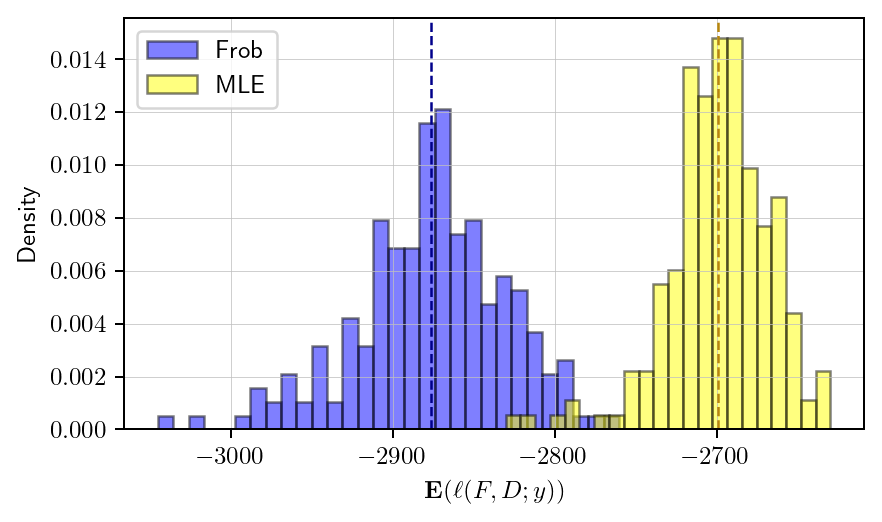

In [44]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

mean1, std1 = np.mean(ll_distribution["frob"]["exp"]), np.std(ll_distribution["frob"]["exp"])
mean2, std2 = np.mean(ll_distribution["mle"]["exp"]), np.std(ll_distribution["mle"]["exp"])

print(len(ll_distribution["frob"]["exp"]), "samples in histogram")

plt.hist(ll_distribution["frob"]["exp"], bins=30, alpha=0.5, color='blue', label='Frob', density=True, edgecolor='black')
plt.hist(ll_distribution["mle"]["exp"], bins=22, alpha=0.5, color='yellow', label='MLE', density=True, edgecolor='black')

plt.axvline(mean1, color='darkblue', linestyle='--', linewidth=1)
plt.axvline(mean2, color='darkgoldenrod', linestyle='--', linewidth=1)

# plt.title('Distribution of expected log-likelihoods')
plt.xlabel(r'$\mathbf{E} (\ell(F, D; y))$')
plt.ylabel('Density')
plt.legend()
plt.grid(color='silver', linestyle='-', linewidth=0.3)  # Adjust the color, linestyle, and linewidth
axs.grid(True)
plt.tight_layout()
plt.savefig(f"plots/hist_{filename}.pdf", bbox_inches='tight')

200 samples in histogram


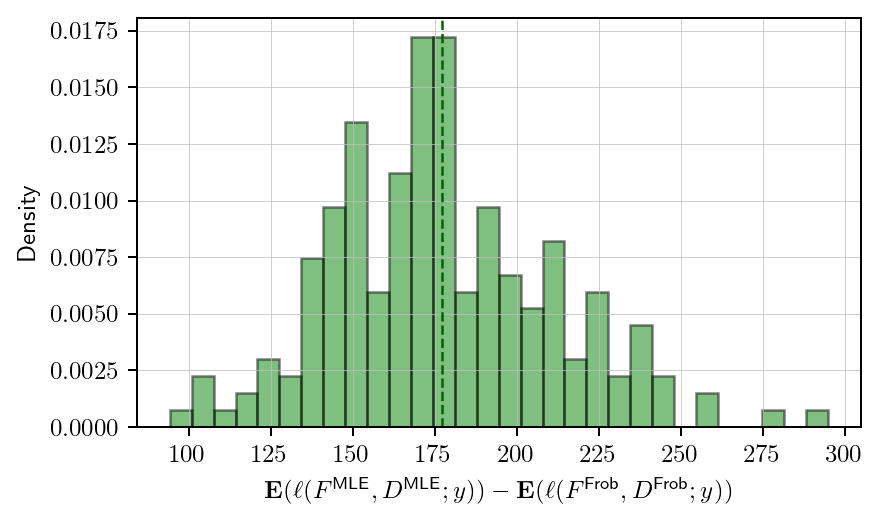

In [50]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

diff = np.array(ll_distribution["mle"]["exp"]) - np.array(ll_distribution["frob"]["exp"])
mean = np.mean(diff)

print(len(ll_distribution["frob"]["exp"]), "samples in histogram")
plt.hist(diff, bins=30, alpha=0.5, color='green', label='MLE', density=True, edgecolor='black')

plt.axvline(mean, color='darkgreen', linestyle='--', linewidth=1)

# plt.title('Distribution of expected log-likelihoods')
plt.xlabel(r'$\mathbf{E} (\ell(F^{\text{MLE}}, D^{\text{MLE}}; y))- \mathbf{E} (\ell(F^{\text{Frob}}, D^{\text{Frob}}; y))$')
plt.ylabel('Density')
# plt.legend()
plt.grid(color='silver', linestyle='-', linewidth=0.3)  
axs.grid(True)
plt.tight_layout()
plt.savefig(f"plots/hist_diff_{filename}.pdf", bbox_inches='tight')

In [25]:
n, L, ranks, rank, true_sparse_F.shape

(1000, 5, array([5, 4, 3, 2, 1]), 15, (1000, 77))

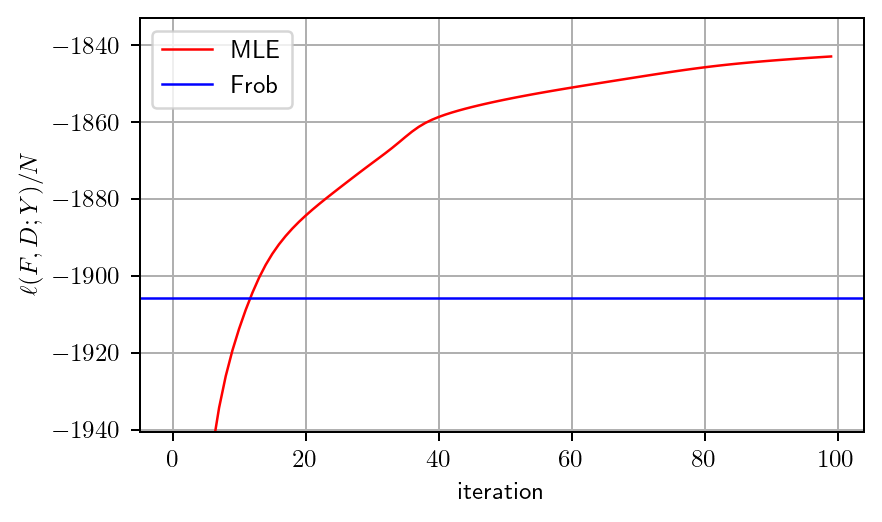

In [41]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

ll = np.array(loglikelihoods[1:])
# print(f"{ranks=}, difference={(ll[-1]-obj_frobs[str(ranks)]["train"]):.2f}, %increase={(ll[-1]-obj_frobs[str(ranks)]["train"])/obj_frobs[str(ranks)]["train"]*100:.2f}")
axs.plot(ll, color='r', lw=1, label=r"$\text{MLE}$")
axs.set_xlabel('iteration')
axs.axhline(obj_frob, 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$")
axs.set_ylabel(r'$\ell(F, D; Y)/N$')
# axs.set_yscale('symlog')
axs.set_ylim([obj_frob - 35, ll.max() + 10])
# axs.axhline(y=true_test_obj, label='True', c='g', alpha=0.5)
axs.grid(True)
axs.legend()
    # axs[i].set_title(f"ranks$={list(ranks)}$")
# plt.show()
plt.tight_layout()
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')

In [42]:
ll_distribution["frob"]["train"][-1], ll_distribution["frob"]["exp"][-1]

(-1905.6623675266042, -2862.397419916)

In [43]:
ll_distribution["mle"]["train"][-1], ll_distribution["mle"]["exp"][-1]

(-1843.0002086839181, -2736.7085650117338)

In [54]:
-1843 + 1904, -2735 + 2862

(61, 127)